In [5]:
""" 데이터 셋 불러오기 """
import os
import struct
import numpy as np

def load_mnist(path, kind = 'train') :
    """ 'path'에서 MNIST 데이터 불러오기 """
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images.idx3-ubyte' % kind)
    
    with open(labels_path, 'rb') as lbpath :
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype = np.uint8)
    
    with open(images_path, 'rb') as imgpath : 
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype = np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2
    
    return images, labels

X_train, y_train = load_mnist('../Dataset/', kind = 'train')
print('행: %d, 열 : %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('../Dataset/', kind = 't10k')
print('행: %d, 열 : %d' % (X_test.shape[0], X_test.shape[1]))

행: 60000, 열 : 784
행: 10000, 열 : 784


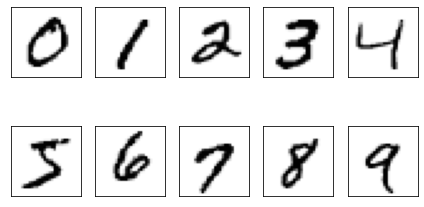

In [6]:
""" 샘플 그림 출력해보기 """
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows = 2, ncols = 5,
                      sharex = True, sharey = True)
ax = ax.flatten()

for i in range(10) : 
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap = 'Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

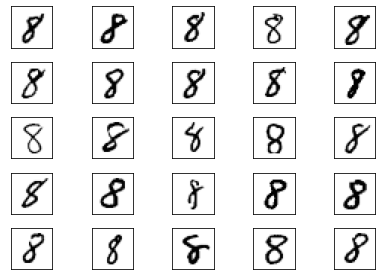

In [10]:
""" 숫자 샘플 여러개 출력해보기 """

fig, ax = plt.subplots(nrows = 5, ncols = 5,
                      sharex = True, sharey = True)
ax = ax.flatten()

for i in range(25) : 
    img = X_train[y_train == 8][i].reshape(28, 28)
    ax[i].imshow(img, cmap = 'Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [12]:
""" savez_compressed로 전처리 오버헤드 피하기 """

np.savez_compressed('mnist_scaled.npz',
                   X_train = X_train, y_train = y_train,
                   X_test = X_test, y_test = y_test)

mnist = np.load('mnist_scaled.npz')

X_train, y_train, X_test, y_test = [mnist[f] for f in mnist.files]

In [22]:
""" 다층 퍼셉트론 구현하기 """
import sys

class NeuralNetMLP(object) : 
    """ 피드포워드 신경망 / 다층 퍼셉트론 분류기
    
    매개변수
    --------
    n_hidden : int (기본값 : 30)
        은닉 유닛 개수
    l2 : float (기본값 : 0)
        L2 규제의 람다 값
        l2 = 0이면 규제 없음.
    epochs : int (기본값 : 100)
        훈련 세트를 반복할 횟수
    eta : float (기본값 : 0.001)
        학습률
    shuffle : bool (기본값 : True)
        에포크마다 훈련 세트를 섞을지 여부
        True면 데이터를 섞어 순서를 바꾼다.
    minibatch_size : int (기본값 : 1)
        미니 배치의 훈련 샘플 개수
    seed : int (기본값 : None)
        가중치와 데이터 셔플링을 위한 난수 초깃값
        
    속성
    ----
    eval_ : dict
        훈련 에포크마다 비용, 훈련 정확도, 검증 정확도를 수집하기 위한 딕셔너리
    """
    
    def __init__(self, n_hidden = 30, l2 = 0., epochs = 100, eta = 0.001,
                shuffle = True, minibatch_size = 1, seed = None) : 
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        
    def _onehot(self, y, n_classes) : 
        """ 레이블을 원-핫 방식으로 인코딩
        
        매개변수
        --------
        y : 배열, 크기 = [n_samples]
            타깃 값
            
        반환값
        ------
        onehot : 배열, 크기 = (n_samples, n_labels)
        """
        
        onehot = np.zeros((n_classes, y.shape[0]))
        
        for idx, val in enumerate(y.astype(int)) : 
            onehot[val, idx] = 1.
        
        return onehot.T
    
    def _sigmoid(self, z) : 
        """로지스틱 함수 (시그모이드) 계산 """
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def _forward(self, X) : 
        """ 정방향 계산 수행 """
        
        # 단계 1 : 은닉층의 최종 입력
        # [n_samples, n_features] dot [n_features, n_hidden] -> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h
        
        # 단계 2 : 은닉층의 활성화 출력
        a_h = self._sigmoid(z_h)
        
        # 단계 3 : 출력층의 최종 입력
        # [n_samples, n_hidden] dot [n_hidden, n_classlabels] -> [n_samples, n_classlabels]
        z_out = np.dot(a_h, self.w_out) + self.b_out
        
        # 단계 4 : 출력층의 활성화 출력
        a_out = self._sigmoid(z_out)
        
        return z_h, a_h, z_out, a_out
    
    def _compute_cost(self, y_enc, output) : 
        """비용 함수를 계산
        
        매개변수
        --------
        y_enc : 배열, 크기 = (n_samples, n_labels)
            원-핫 인코딩된 클래스 레이블
        output : 배열, 크기 = [n_samples, n_output_units]
            출력층의 활성화 출력 (정방향 계산)
        
        반환값
        ------
        cost : float
            규제가 포함된 비용
        """
        
        L2_term = (self.l2 * (np.sum(self.w_h ** 2.) + np.sum(self.w_out ** 2.)))
        
        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        
        return cost
    
    def predict(self, X) : 
        """ 클래스 레이블 예측
        
        매개변수
        --------
        X : 배열, 크기 = [n_samples, n_features]
            원본 특성의 입력층
            
        반환값
        ------
        y_pred : 배열, 크기 = [n_samples]
            예측된 클래스 레이블
        """
        
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis = 1)
        return y_pred
    
    def fit(self, X_train, y_train, X_valid, y_valid) : 
        """ 훈련 데이터에서 가중치를 학습 
        
        매개변수
        --------
        X_train : 배열, 크기 = [n_samples, n_features]
            원본 특성의 입력층
        y_train : 배열, 크기 = [n_samples]
            타깃 클래스 레이블
        X_valid : 배열, 크기 = [n_samples, n_features]
            훈련하는 동안 검증에 사용할 샘플 특성
        y_valid : 배열, 크기 = [n_samples]
            훈련하는 동안 검증에 사용할 샘플 레이블
            
        반환값
        ------
        self
        """
        
        n_output = np.unique(y_train).shape[0] # 클래스 레이블 개수
        n_features = X_train.shape[1]
        
        #################
        # 가중치 초기화 #
        #################
        
        # 입력층 -> 은닉층 사이의 가중치
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc = 0.0, scale = 0.1,
                                     size = (n_features, self.n_hidden))
        
        # 은닉층 -> 출력층 사이의 가중치
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc = 0.0, scale = 0.1,
                                       size = (self.n_hidden, n_output))
        
        epoch_strlen = len(str(self.epochs)) # 출력 포맷을 위함
        self.eval_ = {'cost' : [], 'train_acc' : [], 'valid_acc' : []}
        
        y_train_enc = self._onehot(y_train, n_output)
        
        # 훈련 에포크를 반복
        for i in range(self.epochs) : 
            # 미니 배치로 반복
            indices = np.arange(X_train.shape[0])
            
            if self.shuffle : 
                self.random.shuffle(indices)
                
            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size) :
                batch_idx = indices[start_idx : start_idx + self.minibatch_size]
            
                # 정방향 계산
                z_h, a_h, z_oit, a_out = self._forward(X_train[batch_idx])
                
                ##########
                # 역전파 #
                ##########
                
                # [n_samples, n_classlabels]
                sigma_out = a_out - y_train_enc[batch_idx]
                
                # [n_samples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)
                
                # [n_samples, n_classlabels] dot [n_classlabels, n_hidden] -> [n_samples, n_hidden]
                sigma_h = (np.dot(sigma_out, self.w_out.T) * sigmoid_derivative_h)
                
                # [n_features, n_samples] dot [n_samples, n_hidden] -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis = 0)
                
                # [n_hidden, n_samples] dot [n_samples, n_classlabels] -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis = 0)
                
                # 규제와 가중치 업데이트
                delta_w_h = (grad_w_h + self.l2 * self.w_h)
                delta_b_h = grad_b_h # 편향은 규제하지 않음
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h
                
                delta_w_out = (grad_w_out + self.l2 * self.w_out)
                delta_b_out = grad_b_out
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out
            
            ########
            # 평가 #
            ########
            
            # 훈련하는 동안 에포크마다 평가
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc = y_train_enc, output = a_out)
            
            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
            
            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) / X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) / X_valid.shape[0])
            
            sys.stderr.write('\r%0*d/%d | 비용 : %.2f | 훈련/검증 정확도 : %.2f%%/%.2f%% ' %
                            (epoch_strlen, i + 1, self.epochs, cost, train_acc * 100, valid_acc * 100))
            sys.stderr.flush()
            
            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)
            
        return self

In [23]:
""" MLP 만들기 """

nn = NeuralNetMLP(n_hidden = 100, l2 = 0.01, epochs = 200, eta = 0.0005,
                 minibatch_size = 100, shuffle = True, seed = 1)
nn.fit(X_train = X_train[:55000], y_train = y_train[:55000],
      X_valid = X_train[55000:], y_valid = y_train[55000:])

200/200 | 비용 : 5065.78 | 훈련/검증 정확도 : 99.28%/97.98%  

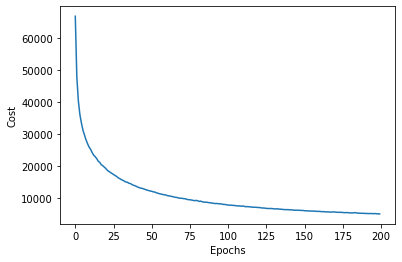

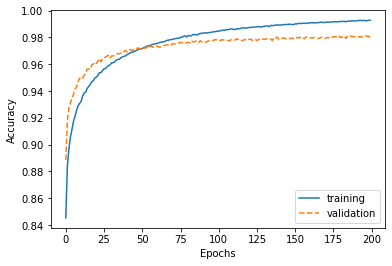

In [28]:
""" 결과 시각화 """

plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

plt.plot(range(nn.epochs), nn.eval_['train_acc'], label = 'training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], label = 'validation',
        linestyle = '--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [29]:
""" 모델 일반화 성능 평가 """

y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred).astype(np.float) / X_test.shape[0])
print('테스트 정확도 : %.2f%%' % (acc * 100))

테스트 정확도 : 97.54%


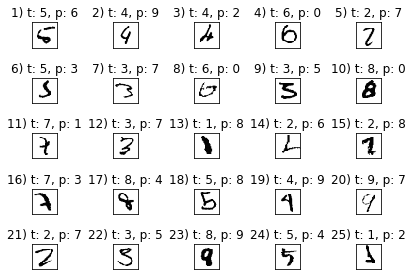

In [32]:
""" MLP 구현이 샘플 이미지를 어떻게 판단하는지 알아보기 """

miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows = 5, ncols = 5,
                      sharex = True, sharey = True)
ax = ax.flatten()

for i in range(25) : 
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap = 'Greys',
                interpolation = 'nearest')
    ax[i].set_title('%d) t: %d, p: %d' % (i+1, correct_lab[i], miscl_lab[i]))
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()